<a href="https://colab.research.google.com/github/GDReallyGoodMan/Prediction-of-whether-a-character-from-Game-of-Thrones-will-survive/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание: выживет ли персонаж из игры престолов

In [11]:
# Библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pd.set_option('display.max_columns', 200)
sns.set(style='whitegrid')

## 1) Загрузка данных


In [12]:
!gdown 1h99toeF7lZ2I3iJwehgKO-QQmDaOe_O3 # test dataset
!gdown 1XL0VTygpZj-ZAuTNRBgApZTPQyNDnT-v # train dataset
df = pd.read_csv("/content/game_of_thrones_train.csv", index_col="S.No")

Downloading...
From: https://drive.google.com/uc?id=1h99toeF7lZ2I3iJwehgKO-QQmDaOe_O3
To: /content/game_of_thrones_test.csv
100% 37.3k/37.3k [00:00<00:00, 40.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XL0VTygpZj-ZAuTNRBgApZTPQyNDnT-v
To: /content/game_of_thrones_train.csv
100% 138k/138k [00:00<00:00, 142MB/s]


## 2) Краткий обзор данных (EDA)

Проверим форму, типы данных и пропуски.

In [13]:
# Быстрый обзор
print('Форма датафрейма:', None if 'df' not in globals() else df.shape)
if 'df' in globals():
    display(df.head())
    print('\nТипы данных:')
    print(df.dtypes.value_counts())
    print('\nКоличество пропусков по столбцам:')
    print(df.isna().sum().sort_values(ascending=False).head(20))

Форма датафрейма: (1557, 25)


,name,title,male,culture,dateOfBirth,mother,father,heir,house,spouse,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
S.No,,,,,,,,,,,,,,,,,,,,,,,,,
1,Viserys II Targaryen,NaN,1,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,0.605351,0
2,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,0.896321,1
3,Addison Hill,Ser,1,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.267559,1
4,Aemma Arryn,Queen,0,NaN,82.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0.183946,0
5,Sylva Santagar,Greenstone,0,Dornish,276.0,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0.043478,1



Типы данных:
int64      10
object      8
float64     7
Name: count, dtype: int64

Количество пропусков по столбцам:
mother           1539
isAliveMother    1539
heir             1536
isAliveHeir      1536
father           1535
isAliveFather    1535
spouse           1357
isAliveSpouse    1357
dateOfBirth      1278
age              1278
culture          1069
title             840
house             381
male                0
name                0
book3               0
book1               0
book4               0
book5               0
book2               0
dtype: int64


## 3) Предобработка

Шаги предобработки:

1. Заполнение пропусков: числовые — медианой, категориальные — строкой `'missing'`.
2. One-hot кодирование всех категориальных признаков (кроме целевой, если она категориальная).
3. Удаление сильно коррелированных признаков (threshold = 0.90).

In [14]:
# Функции для предобработки и отбора
def detect_target(df, target_name=None):
    if target_name:
        if target_name in df.columns:
            return target_name
        else:
            raise KeyError(f"Целевая колонка {target_name} не найдена в df.columns")
    # Попытки автодетекции
    for cand in df.columns:
        if cand.lower() in ('survived','surv','is_alive','alive','target'):
            return cand
    for cand in df.columns:
        if 'surv' in cand.lower() or 'alive' in cand.lower():
            return cand
    raise KeyError('Не удалось автоматически определить целевую колонку. Укажите target_name вручную.')

def preprocess_df(df, target_col):
    df = df.copy()
    # заполнение числовых NA медианой
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(df[col].median())
    # заполнение категориальных NA
    for col in df.select_dtypes(include=['object','category']).columns:
        df[col] = df[col].fillna('missing')
    # one-hot для категорий (кроме целевой)
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    if target_col in cat_cols:
        cat_cols.remove(target_col)
    if cat_cols:
        df = pd.get_dummies(df, columns=cat_cols, dummy_na=False)
    return df

def drop_highly_correlated(df, threshold=0.90):
    # Рассчитываем абсолютную матрицу корреляций и удаляем один из пар с corr > threshold
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop, corr

### 3.1 Выполнить предобработку и удалить сильнокоррелированные признаки

In [15]:
target_name = None

if 'df' not in globals():
    raise RuntimeError('df не найден. Сначала загрузите данные в ячейку "Загрузка данных".')

target = detect_target(df, target_name=target_name)
print('Найдена целевая колонка:', target)

df_proc = preprocess_df(df, target)
print('Размерность после one-hot:', df_proc.shape)

# Если целевая колонка была категориальной и превратилась в dummies, постараемся восстановить одну колонку
if target not in df_proc.columns:
    tcols = [c for c in df_proc.columns if c.startswith(target + '_')]
    if len(tcols) == 1:
        df_proc[target] = df_proc[tcols[0]]
    elif len(tcols) > 1:
        # например, target_A, target_B — выбираем колонку соответствующую '1'
        print('Целевая колонка превратилась в несколько dummies:', tcols[:10])
        raise RuntimeError('Укажите явную целевую колонку в target_name, когда target был категориальным.')

# Отделим X и y для корреляционного анализа (X только числовые признаки)
numeric_df = df_proc.select_dtypes(include=[np.number]).copy()
# удалим целевой столбец из корреляций
if target in numeric_df.columns:
    numeric_df_for_corr = numeric_df.drop(columns=[target])
else:
    numeric_df_for_corr = numeric_df

to_drop, corr_matrix = drop_highly_correlated(numeric_df_for_corr, threshold=0.90)
print('Признаки, рекомендованные к удалению из-за высокой корреляции (threshold=0.90):', to_drop)
if to_drop:
    df_proc.drop(columns=to_drop, inplace=True)
    print('Новая размерность после удаления скоррелированных столбцов:', df_proc.shape)

Найдена целевая колонка: isAliveMother
Размерность после one-hot: (1557, 2383)
Признаки, рекомендованные к удалению из-за высокой корреляции (threshold=0.90): []


### Визуализация матрицы корреляций (в числовых признаках)

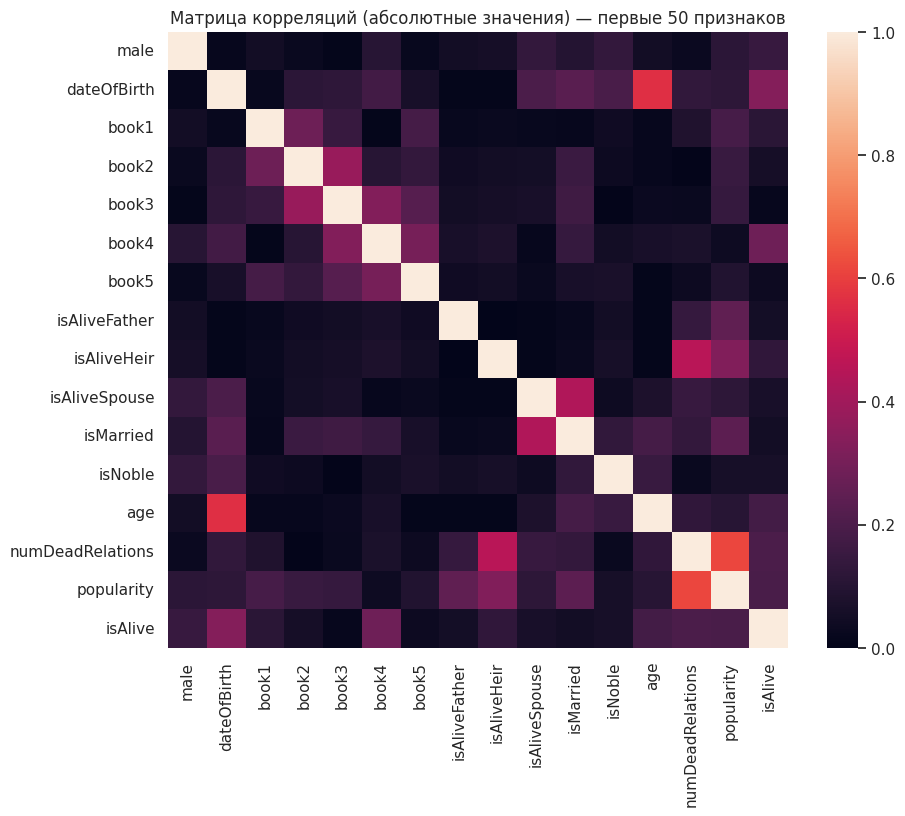

In [16]:
# Визуализация (ограничим размер для удобства)
plt.figure(figsize=(10,8))
# берем только первые 50 числовых признаков, если их слишком много
num_cols = numeric_df_for_corr.columns.tolist()[:50]
sns.heatmap(corr_matrix.loc[num_cols, num_cols], vmin=0, vmax=1)
plt.title('Матрица корреляций (абсолютные значения) — первые 50 признаков')
plt.show()

## 4) Обучение и оценка моделей

Сравним две модели:

- LogisticRegression (линейная модель для классификации)
- RandomForestClassifier — базовый сильный baseline

Подбираем гиперпараметры с помощью GridSearchCV и выбираем модель с лучшей accuracy на тестовой выборке.

In [17]:
# Обучение: LogisticRegression vs RandomForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# подготовка X, y
y = df_proc[target]
X = df_proc.drop(columns=[target])

# если y строковый — факторизуем
if y.dtype == object:
    y = pd.factorize(y)[0]

# стратифицированное разделение
strat = y if len(np.unique(y)) > 1 else None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=strat)
print('Train/test shapes:', X_train.shape, X_test.shape)

# LogisticRegression pipeline + GridSearch
pipe_logreg = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(solver='liblinear', max_iter=1000))])
logreg_params = {'logreg__C': [0.01, 0.1, 1, 10]}
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
gs_logreg = GridSearchCV(pipe_logreg, logreg_params, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
gs_logreg.fit(X_train, y_train)
best_logreg = gs_logreg.best_estimator_
y_pred_logreg = best_logreg.predict(X_test)
acc_logreg = accuracy_score(y_test, y_pred_logreg)
print('\nLogisticRegression best params:', gs_logreg.best_params_, 'Test accuracy:', acc_logreg)
print('Classification report (LogReg):\n', classification_report(y_test, y_pred_logreg, zero_division=0))

# RandomForest baseline + GridSearch
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10]}
gs_rf = GridSearchCV(rf, rf_params, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)
best_rf = gs_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print('\nRandomForest best params:', gs_rf.best_params_, 'Test accuracy:', acc_rf)
print('Classification report (RF):\n', classification_report(y_test, y_pred_rf, zero_division=0))

# Выбираем лучшую модель
if acc_logreg >= acc_rf:
    chosen_name, chosen_model, chosen_acc, chosen_pred = 'LogisticRegression', best_logreg, acc_logreg, y_pred_logreg
else:
    chosen_name, chosen_model, chosen_acc, chosen_pred = 'RandomForest', best_rf, acc_rf, y_pred_rf
print(f'\nВыбрана модель: {chosen_name} с accuracy = {chosen_acc:.4f}')

# Показать матрицу ошибок для выбранной модели
print('Confusion matrix:')
print(confusion_matrix(y_test, chosen_pred))

Train/test shapes: (1245, 2382) (312, 2382)
Fitting 4 folds for each of 4 candidates, totalling 16 fits

LogisticRegression best params: {'logreg__C': 0.01} Test accuracy: 1.0
Classification report (LogReg):
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      1.00      1.00       311

    accuracy                           1.00       312
   macro avg       1.00      1.00      1.00       312
weighted avg       1.00      1.00      1.00       312

Fitting 4 folds for each of 4 candidates, totalling 16 fits

RandomForest best params: {'max_depth': None, 'n_estimators': 100} Test accuracy: 0.9967948717948718
Classification report (RF):
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      1.00      1.00       311

    accuracy                           1.00       312
   macro avg       0.50      0.50      0.50       312
w

### 4.1 Важность признаков / Коэффициенты

Для RandomForest — feature_importances_. Для LogisticRegression — коэффициенты модели (в стандартизованном виде).

In [18]:
# Важность признаков
if chosen_name == 'RandomForest':
    importances = pd.Series(chosen_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(30)
    print('Топ-30 важных признаков (RandomForest):\n', importances)
else:
    # логистическая регрессия в пайплайне: scaler + logreg
    if isinstance(chosen_model, Pipeline):
        logreg = chosen_model.named_steps['logreg']
        scaler = chosen_model.named_steps['scaler']
        # коэффициенты соответствуют масштабу после стандартизации; просто выведем отсортированно по абсолютному значению
        coefs = pd.Series(logreg.coef_.ravel(), index=X.columns).sort_values(key=lambda x: x.abs(), ascending=False).head(30)
        print('Топ-30 коэффициентов (LogisticRegression) по абсолютному значению:\n', coefs)
    else:
        print('Модель не представлена в ожидаемом формате для извлечения коэффициентов.')

Топ-30 коэффициентов (LogisticRegression) по абсолютному значению:
 father_Aegon I Targaryen             -0.071460
heir_Jaehaerys Targaryen             -0.050518
name_Maegor I Targaryen              -0.050518
mother_Visenya Targaryen             -0.050518
name_Aenys I Targaryen               -0.050501
heir_Aegon Targaryen                 -0.050501
mother_Rhaenys Targaryen             -0.050501
name_Stannis Baratheon               -0.050469
heir_Shireen Baratheon               -0.050469
father_Steffon Baratheon             -0.050469
mother_Cassana Estermont             -0.050469
name_Daeron II Targaryen             -0.050454
mother_Naerys Targaryen              -0.050454
father_Aegon IV Targaryen            -0.050454
heir_Baelor 'Breakspear' Targaryen   -0.050454
name_Robb Stark                      -0.050449
heir_Bran Stark                      -0.050449
mother_Catelyn Stark                 -0.050449
father_Eddard Stark                  -0.050449
mother_missing                        0